# 🫁 EfficientNet-B0 - Chest X-ray Multi-Label Classification

**Dataset:** CheXpert 3-class (Cardiomegaly, Edema, Pneumothorax) - **No Finding Excluded**

**Model:** EfficientNet-B0 (pretrained on ImageNet)

**Outputs:**
- 3 Binary Classification Reports (one per class)
- 3 Binary Confusion Matrices (one per class)
- Training/Validation Loss & Accuracy Curves
- ROC Curves for all 3 classes

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# Torchvision
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Sklearn metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, auc, accuracy_score, f1_score,
    precision_score, recall_score
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: True


## ⚙️ Configuration

In [4]:
class Config:
    # Paths - UPDATE THIS TO YOUR DATASET NAME
    DATA_DIR = "/kaggle/input"  # Your uploaded dataset
    OUTPUT_DIR = "/kaggle/working"
    
    # Model
    MODEL_NAME = "efficientnet_b0"
    NUM_CLASSES = 3
    LABELS = ["Cardiomegaly", "Edema", "Pneumothorax"]  # No Finding excluded
    
    # Training
    BATCH_SIZE = 32
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    
    # Image
    IMG_SIZE = 224
    
    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Random seed
    SEED = 42

config = Config()

# Set seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.SEED)

print(f"🖥️ Device: {config.DEVICE}")
print(f"🤖 Model: {config.MODEL_NAME}")
print(f"🏷️ Labels: {config.LABELS}")

🖥️ Device: cuda
🤖 Model: efficientnet_b0
🏷️ Labels: ['Cardiomegaly', 'Edema', 'Pneumothorax']


## 📦 Dataset Class

In [5]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.labels = config.LABELS
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get image path
        img_path = row['new_path']
        full_path = os.path.join(self.img_dir, img_path)
        
        # Load image
        try:
            image = Image.open(full_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {full_path}: {e}")
            image = Image.new('RGB', (config.IMG_SIZE, config.IMG_SIZE), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        # Get labels (multi-hot encoding)
        labels = []
        for label in self.labels:
            val = row[label] if label in row.index else 0
            labels.append(1.0 if val == 1.0 else 0.0)
        
        labels = torch.tensor(labels, dtype=torch.float32)
        
        return image, labels

## 🔄 Data Transforms

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

## 📊 Load Data

In [7]:
print("=" * 60)
print("LOADING DATA")
print("=" * 60)

# Check what's in the data directory
print(f"\nContents of {config.DATA_DIR}:")
if os.path.exists(config.DATA_DIR):
    for item in os.listdir(config.DATA_DIR):
        print(f"  {item}")
else:
    print(f"  ⚠️ Directory {config.DATA_DIR} not found. Please check dataset path.")

# Load metadata
metadata_path = os.path.join(config.DATA_DIR, "metadata.csv")
if os.path.exists(metadata_path):
    df = pd.read_csv(metadata_path)
    print(f"\n📈 Total samples: {len(df)}")

    # Check label distribution
    print("\n📊 Label distribution:")
    for label in config.LABELS:
        if label in df.columns:
            count = (df[label] == 1.0).sum()
            print(f"  {label}: {count} ({count/len(df)*100:.2f}%)")
else:
    # Fallback for testing without data
    print("⚠️ Metadata file not found. Creating dummy data structure for compilation check.")
    df = pd.DataFrame(columns=['new_path'] + config.LABELS)

LOADING DATA

Contents of /kaggle/input:
  images
  metadata.csv

📈 Total samples: 95060

📊 Label distribution:
  Cardiomegaly: 23451 (24.67%)
  Edema: 49717 (52.30%)
  Pneumothorax: 17700 (18.62%)


In [8]:
# Split data
if len(df) > 0:
    train_df, val_df = train_test_split(
        df, test_size=0.2, random_state=config.SEED, 
        stratify=None
    )
else:
    train_df, val_df = df, df

print(f"🏋️ Train samples: {len(train_df)}")
print(f"🧪 Validation samples: {len(val_df)}")

# Create datasets
train_dataset = ChestXrayDataset(train_df, config.DATA_DIR, train_transform)
val_dataset = ChestXrayDataset(val_df, config.DATA_DIR, val_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

print(f"\n✅ DataLoaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

🏋️ Train samples: 76048
🧪 Validation samples: 19012

✅ DataLoaders created!
   Train batches: 2377
   Val batches: 595


## 🤖 Model Definition - EfficientNet-B0

In [9]:
class EfficientNetChestXray(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super().__init__()
        
        # Load pretrained EfficientNet-B0
        if pretrained:
            weights = EfficientNet_B0_Weights.IMAGENET1K_V1
            self.backbone = efficientnet_b0(weights=weights)
        else:
            self.backbone = efficientnet_b0(weights=None)
        
        # Get the number of features from the backbone
        # EfficientNet's classifier is a Sequential block, we need input of the last layer
        in_features = self.backbone.classifier[1].in_features
        
        # Replace the classifier head
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

# Create model
model = EfficientNetChestXray(num_classes=config.NUM_CLASSES, pretrained=True)
model = model.to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 150MB/s]


📊 Total parameters: 4,664,959
📊 Trainable parameters: 4,664,959


## 🎯 Training Setup

In [10]:
# Loss function (BCE for multi-label)
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(
    model.parameters(), 
    lr=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY
)

# Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=config.NUM_EPOCHS, eta_min=1e-6)

print("✅ Training setup complete!")
print(f"   Loss: BCEWithLogitsLoss")
print(f"   Optimizer: AdamW (LR={config.LEARNING_RATE})")
print(f"   Scheduler: CosineAnnealingLR")

✅ Training setup complete!
   Loss: BCEWithLogitsLoss
   Optimizer: AdamW (LR=0.0001)
   Scheduler: CosineAnnealingLR


## 🔧 Training Functions

In [11]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Use tqdm for progress bar if loader is not empty
    if len(loader) > 0:
        pbar = tqdm(loader, desc="Training")
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Collect predictions
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        epoch_loss = running_loss / len(loader)
    else:
        epoch_loss = 0.0
    
    # Calculate accuracy (threshold = 0.5)
    if len(all_preds) > 0:
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        binary_preds = (all_preds > 0.5).astype(int)
        accuracy = (binary_preds == all_labels).mean()
    else:
        accuracy = 0.0
    
    return epoch_loss, accuracy

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        if len(loader) > 0:
            pbar = tqdm(loader, desc="Validation")
            for images, labels in pbar:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                
                probs = torch.sigmoid(outputs).cpu().numpy()
                all_probs.extend(probs)
                all_preds.extend((probs > 0.5).astype(int))
                all_labels.extend(labels.cpu().numpy())
            
            epoch_loss = running_loss / len(loader)
        else:
            epoch_loss = 0.0
    
    # Calculate accuracy
    if len(all_preds) > 0:
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        accuracy = (all_preds == all_labels).mean()
    else:
        accuracy = 0.0
        all_preds, all_labels, all_probs = np.array([]), np.array([]), np.array([])
    
    return epoch_loss, accuracy, all_preds, all_probs, all_labels

## 🏋️ Training Loop

In [12]:
print("=" * 60)
print("🚀 TRAINING STARTED - EfficientNet-B0")
print("=" * 60)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_loss = float('inf')
best_model_state = None

# Check if we have data to train
if len(train_loader) > 0:
    for epoch in range(10):
        print(f"\n📅 Epoch {epoch+1}/{10}")
        print("-" * 40)
        
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, config.DEVICE
        )
        
        # Validate
        val_loss, val_acc, val_preds, val_probs, val_labels = validate_epoch(
            model, val_loader, criterion, config.DEVICE
        )
        
        # Update scheduler
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print metrics
        print(f"📉 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"📊 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"📈 LR: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print("✅ Best model saved!")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
        # Save model
        model_path = os.path.join(config.OUTPUT_DIR, "efficientnet_chestxray.pth")
        torch.save(best_model_state, model_path)
        print(f"\n💾 Model saved to: {model_path}")
else:
    print("⚠️ No training data available. Skipping training loop.")

🚀 TRAINING STARTED - EfficientNet-B0

📅 Epoch 1/10
----------------------------------------


Validation: 100%|██████████| 595/595 [02:06<00:00,  4.69it/s]


📉 Train Loss: 0.4154 | Train Acc: 0.8130
📊 Val Loss: 0.3782 | Val Acc: 0.8328
📈 LR: 0.000100
✅ Best model saved!

📅 Epoch 2/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:50<00:00, 11.73it/s]


📉 Train Loss: 0.3626 | Train Acc: 0.8412
📊 Val Loss: 0.3751 | Val Acc: 0.8371
📈 LR: 0.000098
✅ Best model saved!

📅 Epoch 3/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:54<00:00, 10.87it/s]


📉 Train Loss: 0.3317 | Train Acc: 0.8563
📊 Val Loss: 0.3686 | Val Acc: 0.8411
📈 LR: 0.000097
✅ Best model saved!

📅 Epoch 4/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:59<00:00, 10.03it/s]


📉 Train Loss: 0.2973 | Train Acc: 0.8720
📊 Val Loss: 0.3887 | Val Acc: 0.8396
📈 LR: 0.000094

📅 Epoch 5/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:57<00:00, 10.43it/s]


📉 Train Loss: 0.2608 | Train Acc: 0.8891
📊 Val Loss: 0.4167 | Val Acc: 0.8382
📈 LR: 0.000091

📅 Epoch 6/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:50<00:00, 11.86it/s]


📉 Train Loss: 0.2231 | Train Acc: 0.9074
📊 Val Loss: 0.4416 | Val Acc: 0.8265
📈 LR: 0.000087

📅 Epoch 7/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:51<00:00, 11.63it/s]


📉 Train Loss: 0.1906 | Train Acc: 0.9210
📊 Val Loss: 0.4975 | Val Acc: 0.8286
📈 LR: 0.000082

📅 Epoch 8/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:51<00:00, 11.53it/s]


📉 Train Loss: 0.1627 | Train Acc: 0.9341
📊 Val Loss: 0.5499 | Val Acc: 0.8301
📈 LR: 0.000077

📅 Epoch 9/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:48<00:00, 12.29it/s]


📉 Train Loss: 0.1401 | Train Acc: 0.9436
📊 Val Loss: 0.5806 | Val Acc: 0.8246
📈 LR: 0.000072

📅 Epoch 10/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:49<00:00, 11.91it/s]

📉 Train Loss: 0.1206 | Train Acc: 0.9521
📊 Val Loss: 0.6219 | Val Acc: 0.8265
📈 LR: 0.000066

💾 Model saved to: /kaggle/working/efficientnet_chestxray.pth


In [13]:


# Check if we have data to train
if len(train_loader) > 0:
    for epoch in range(10):
        print(f"\n📅 Epoch {epoch+1}/{10}")
        print("-" * 40)
        
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, config.DEVICE
        )
        
        # Validate
        val_loss, val_acc, val_preds, val_probs, val_labels = validate_epoch(
            model, val_loader, criterion, config.DEVICE
        )
        
        # Update scheduler
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print metrics
        print(f"📉 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"📊 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"📈 LR: {scheduler.get_last_lr()[0]:.6f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print("✅ Best model saved!")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
        # Save model
        model_path = os.path.join(config.OUTPUT_DIR, "efficientnet_chestxray.pth")
        torch.save(best_model_state, model_path)
        print(f"\n💾 Model saved to: {model_path}")
else:
    print("⚠️ No training data available. Skipping training loop.")


📅 Epoch 1/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:59<00:00,  9.97it/s]


📉 Train Loss: 0.1054 | Train Acc: 0.9580
📊 Val Loss: 0.6783 | Val Acc: 0.8280
📈 LR: 0.000060

📅 Epoch 2/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:50<00:00, 11.77it/s]


📉 Train Loss: 0.0916 | Train Acc: 0.9638
📊 Val Loss: 0.7061 | Val Acc: 0.8260
📈 LR: 0.000054

📅 Epoch 3/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:52<00:00, 11.31it/s]


📉 Train Loss: 0.0792 | Train Acc: 0.9692
📊 Val Loss: 0.7523 | Val Acc: 0.8262
📈 LR: 0.000047

📅 Epoch 4/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:51<00:00, 11.56it/s]


📉 Train Loss: 0.0707 | Train Acc: 0.9728
📊 Val Loss: 0.7770 | Val Acc: 0.8284
📈 LR: 0.000041

📅 Epoch 5/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:52<00:00, 11.39it/s]


📉 Train Loss: 0.0625 | Train Acc: 0.9760
📊 Val Loss: 0.8038 | Val Acc: 0.8251
📈 LR: 0.000035

📅 Epoch 6/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:49<00:00, 12.04it/s]


📉 Train Loss: 0.0559 | Train Acc: 0.9786
📊 Val Loss: 0.8569 | Val Acc: 0.8268
📈 LR: 0.000029

📅 Epoch 7/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:47<00:00, 12.40it/s]


📉 Train Loss: 0.0489 | Train Acc: 0.9816
📊 Val Loss: 0.9095 | Val Acc: 0.8276
📈 LR: 0.000024

📅 Epoch 8/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:50<00:00, 11.70it/s]


📉 Train Loss: 0.0449 | Train Acc: 0.9831
📊 Val Loss: 0.9109 | Val Acc: 0.8235
📈 LR: 0.000019

📅 Epoch 9/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:51<00:00, 11.54it/s]


📉 Train Loss: 0.0403 | Train Acc: 0.9849
📊 Val Loss: 0.9501 | Val Acc: 0.8278
📈 LR: 0.000014

📅 Epoch 10/10
----------------------------------------


Validation: 100%|██████████| 595/595 [00:49<00:00, 11.93it/s]

📉 Train Loss: 0.0359 | Train Acc: 0.9865
📊 Val Loss: 0.9637 | Val Acc: 0.8277
📈 LR: 0.000010

💾 Model saved to: /kaggle/working/efficientnet_chestxray.pth


## 📈 Plot Training Curves

/tmp/ipykernel_55/1875592412.py:22: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/1875592412.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/1875592412.py:23: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(config.OUTPUT_DIR, 'efficientnet_training_curves.png'), dpi=300, bbox_inches='tight')
/tmp/ipykernel_55/1875592412.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(config.OUTPUT_DIR, 'efficientnet_training_curves.png'), dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/li

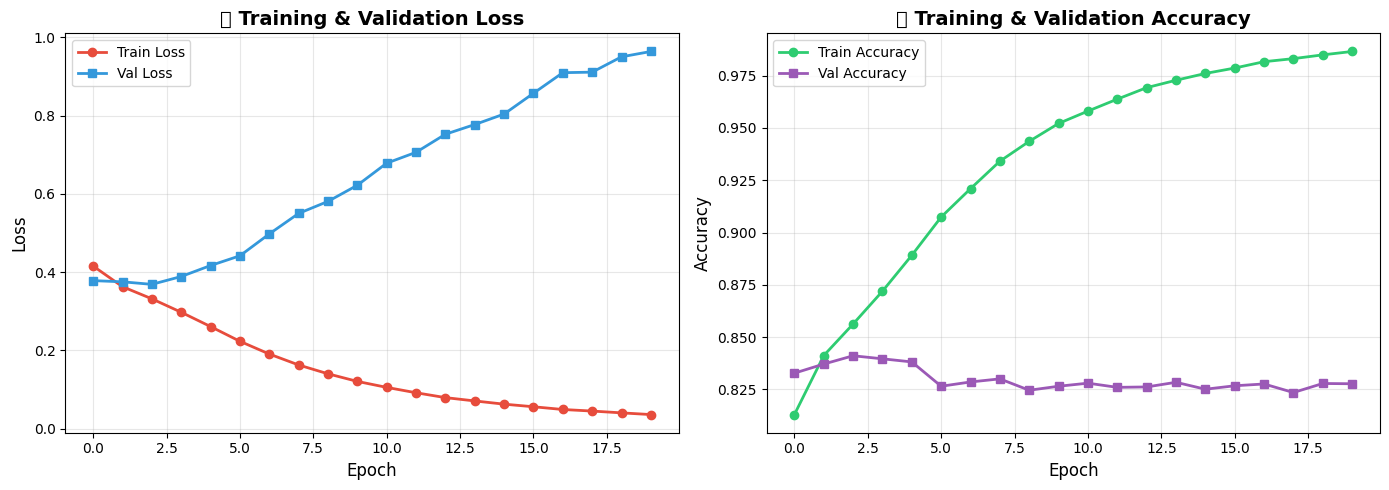

✅ Saved: efficientnet_training_curves.png


In [1]:
if len(history['train_loss']) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2, color='#e74c3c')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2, color='#3498db')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('📉 Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Accuracy curve
    axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2, color='#2ecc71')
    axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2, color='#9b59b6')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('📈 Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'efficientnet_training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: efficientnet_training_curves.png")
else:
    print("⚠️ No training history to plot.")

## 🔍 Final Evaluation

In [2]:
print("=" * 60)
print("🔍 FINAL EVALUATION")
print("=" * 60)

# Get final predictions
if len(val_loader) > 0 and best_model_state is not None:
    val_loss, val_acc, all_preds, all_probs, all_labels = validate_epoch(
        model, val_loader, criterion, config.DEVICE
    )

    print(f"\n📊 Final Validation Loss: {val_loss:.4f}")
    print(f"📊 Final Validation Accuracy: {val_acc:.4f}")
else:
    print("⚠️ Skipping evaluation due to missing data or model.")
    all_preds, all_probs, all_labels = [], [], []

🔍 FINAL EVALUATION


Validation: 100%|██████████| 595/595 [02:00<00:00,  4.93it/s]


📊 Final Validation Loss: 0.9637
📊 Final Validation Accuracy: 0.8277


## 📊 4 Binary Confusion Matrices

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykernel_55/2683872131.py:26: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/2683872131.py:27: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(config.OUTPUT_DIR, 'efficientnet_confusion_matrices.png'), dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


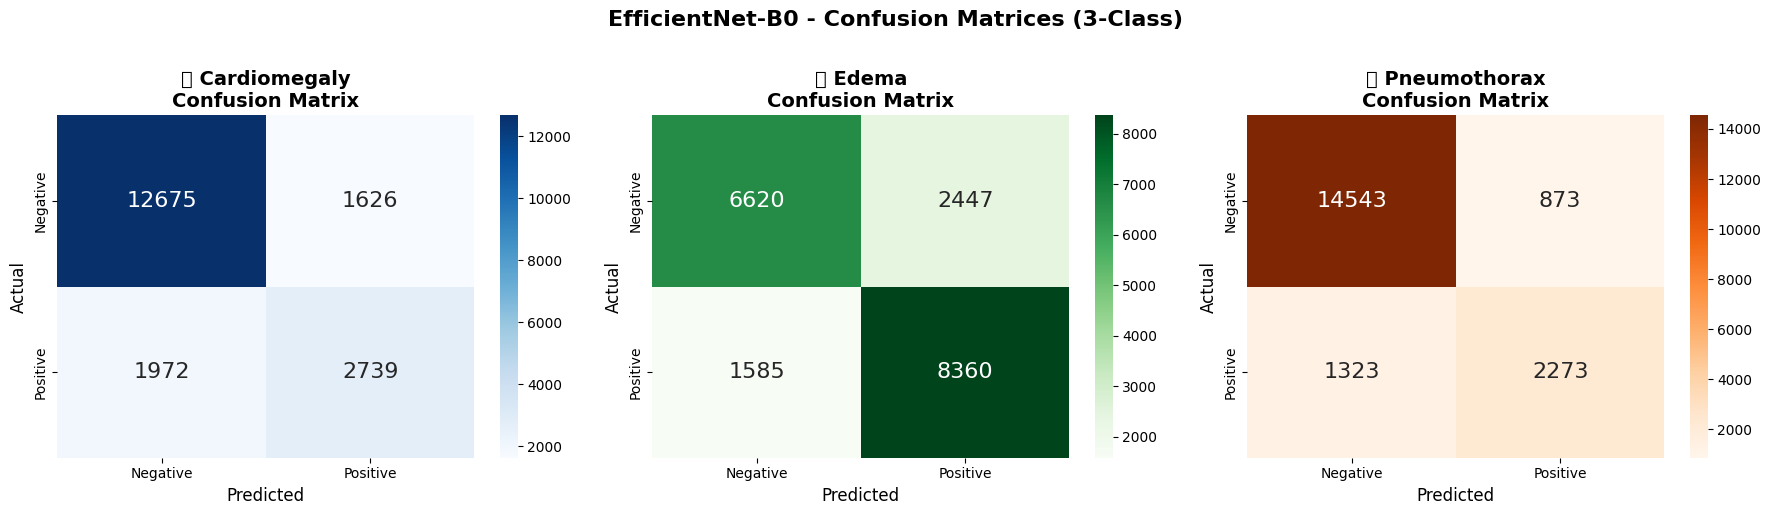

✅ Saved: efficientnet_confusion_matrices.png


In [3]:
if len(all_preds) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    colors = ['Blues', 'Greens', 'Oranges']

    for i, label in enumerate(config.LABELS):
        # Get binary predictions and labels for this class
        class_preds = all_preds[:, i]
        class_labels = all_labels[:, i]
        
        # Compute confusion matrix
        cm = confusion_matrix(class_labels, class_preds)
        
        # Plot
        sns.heatmap(
            cm, annot=True, fmt='d', cmap=colors[i],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=axes[i], annot_kws={'size': 16}
        )
        axes[i].set_xlabel('Predicted', fontsize=12)
        axes[i].set_ylabel('Actual', fontsize=12)
        axes[i].set_title(f'🏷️ {label}\nConfusion Matrix', fontsize=14, fontweight='bold')

    plt.suptitle('EfficientNet-B0 - Confusion Matrices (3-Class)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'efficientnet_confusion_matrices.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: efficientnet_confusion_matrices.png")

## 📋 3 Binary Classification Reports

In [4]:
if len(all_preds) > 0:
    print("=" * 60)
    print("📋 CLASSIFICATION REPORTS (4 Binary)")
    print("=" * 60)

    reports = []

    for i, label in enumerate(config.LABELS):
        print(f"\n{'='*50}")
        print(f"🏷️ CLASSIFICATION REPORT: {label}")
        print('='*50)
        
        class_preds = all_preds[:, i]
        class_labels = all_labels[:, i]
        
        # Print detailed report
        report = classification_report(
            class_labels, class_preds, 
            target_names=['Negative', 'Positive'],
            digits=4
        )
        print(report)
        
        # Calculate individual metrics
        acc = accuracy_score(class_labels, class_preds)
        precision = precision_score(class_labels, class_preds, zero_division=0)
        recall = recall_score(class_labels, class_preds, zero_division=0)
        f1 = f1_score(class_labels, class_preds, zero_division=0)
        
        reports.append({
            'Label': label,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

    # Create summary table
    reports_df = pd.DataFrame(reports)
    print("\n" + "=" * 60)
    print("📊 SUMMARY TABLE")
    print("=" * 60)
    print(reports_df.to_string(index=False))

    # Save reports to CSV
    reports_df.to_csv(os.path.join(config.OUTPUT_DIR, 'efficientnet_classification_reports.csv'), index=False)
    print("\n✅ Saved: efficientnet_classification_reports.csv")

📋 CLASSIFICATION REPORTS (4 Binary)

🏷️ CLASSIFICATION REPORT: Cardiomegaly
              precision    recall  f1-score   support

    Negative     0.8654    0.8863    0.8757     14301
    Positive     0.6275    0.5814    0.6036      4711

    accuracy                         0.8108     19012
   macro avg     0.7464    0.7339    0.7396     19012
weighted avg     0.8064    0.8108    0.8083     19012


🏷️ CLASSIFICATION REPORT: Edema
              precision    recall  f1-score   support

    Negative     0.8068    0.7301    0.7666      9067
    Positive     0.7736    0.8406    0.8057      9945

    accuracy                         0.7879     19012
   macro avg     0.7902    0.7854    0.7861     19012
weighted avg     0.7894    0.7879    0.7870     19012


🏷️ CLASSIFICATION REPORT: Pneumothorax
              precision    recall  f1-score   support

    Negative     0.9166    0.9434    0.9298     15416
    Positive     0.7225    0.6321    0.6743      3596

    accuracy                     

## 📊 Metrics Comparison Chart

/tmp/ipykernel_55/762682478.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/762682478.py:32: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(config.OUTPUT_DIR, 'efficientnet_metrics_comparison.png'), dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


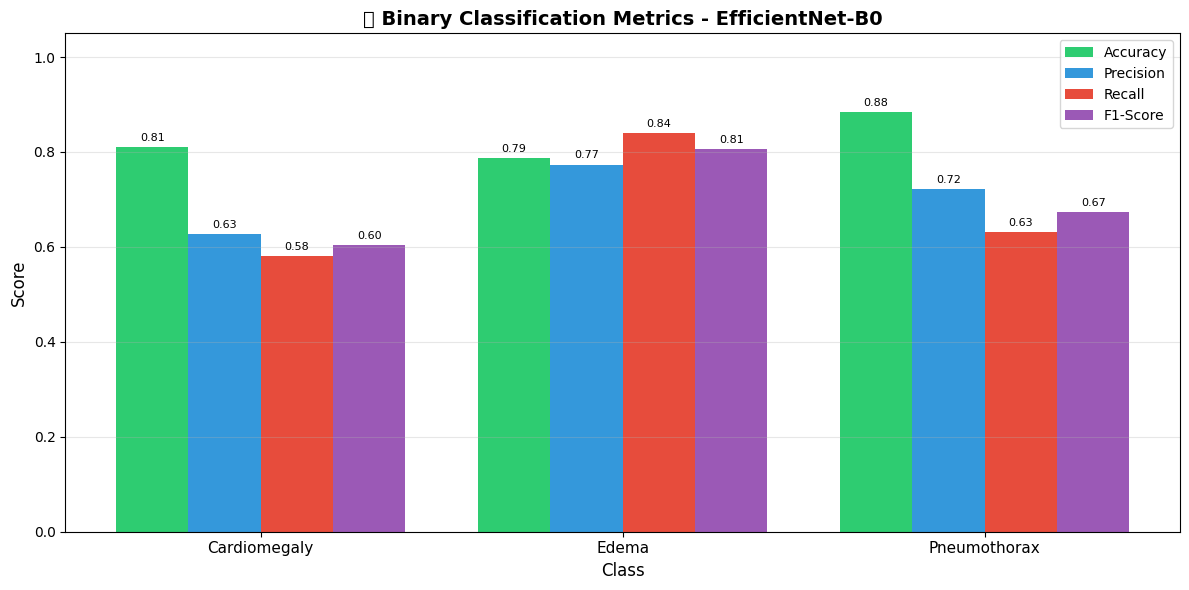

✅ Saved: efficientnet_metrics_comparison.png


In [5]:
if len(all_preds) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(config.LABELS))
    width = 0.2

    bars1 = ax.bar(x - 1.5*width, reports_df['Accuracy'], width, label='Accuracy', color='#2ecc71')
    bars2 = ax.bar(x - 0.5*width, reports_df['Precision'], width, label='Precision', color='#3498db')
    bars3 = ax.bar(x + 0.5*width, reports_df['Recall'], width, label='Recall', color='#e74c3c')
    bars4 = ax.bar(x + 1.5*width, reports_df['F1-Score'], width, label='F1-Score', color='#9b59b6')

    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('📊 Binary Classification Metrics - EfficientNet-B0', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(config.LABELS, fontsize=11)
    ax.legend(fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'efficientnet_metrics_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: efficientnet_metrics_comparison.png")

## 📈 ROC Curves for All 4 Classes

/tmp/ipykernel_55/1787208489.py:28: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/1787208489.py:29: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(config.OUTPUT_DIR, 'efficientnet_roc_curves.png'), dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


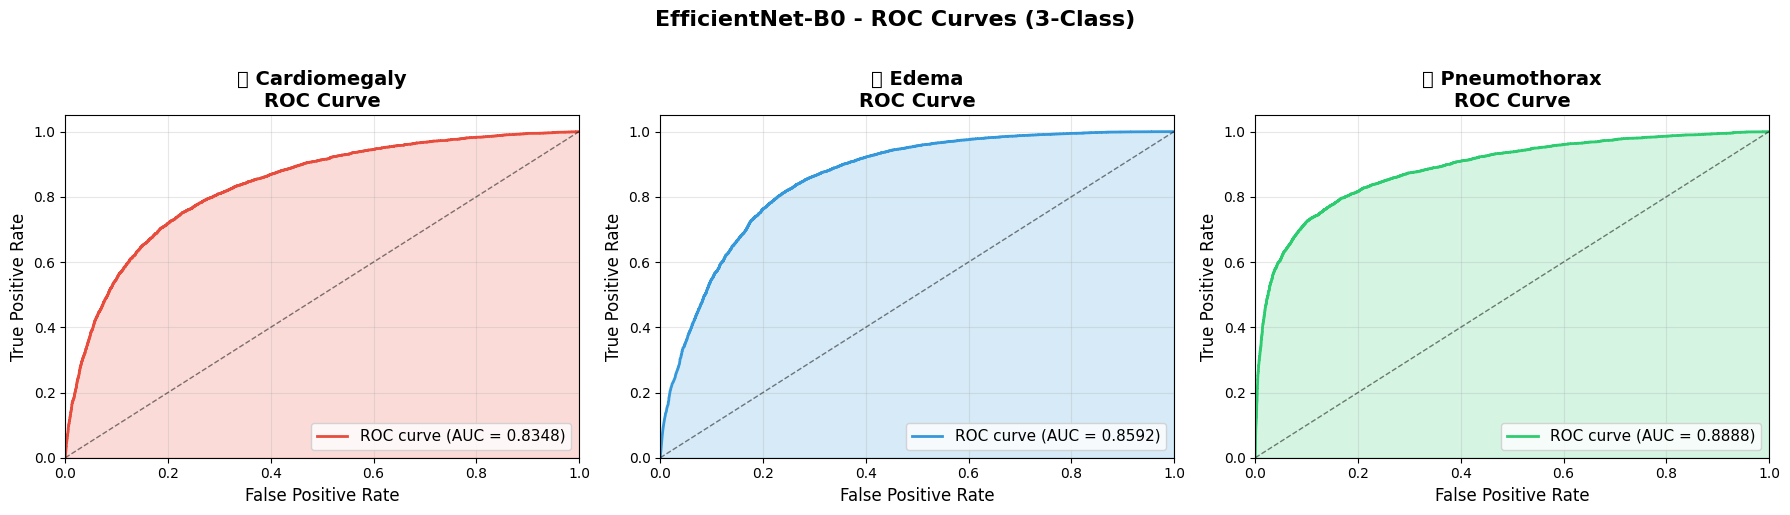

✅ Saved: efficientnet_roc_curves.png


In [6]:
if len(all_preds) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    colors = ['#e74c3c', '#3498db', '#2ecc71']

    for i, label in enumerate(config.LABELS):
        class_probs = all_probs[:, i]
        class_labels = all_labels[:, i]
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(class_labels, class_probs)
        roc_auc = auc(fpr, tpr)
        
        # Plot
        axes[i].plot(fpr, tpr, color=colors[i], linewidth=2, 
                     label=f'ROC curve (AUC = {roc_auc:.4f})')
        axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
        axes[i].fill_between(fpr, tpr, alpha=0.2, color=colors[i])
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate', fontsize=12)
        axes[i].set_ylabel('True Positive Rate', fontsize=12)
        axes[i].set_title(f'🏷️ {label}\nROC Curve', fontsize=14, fontweight='bold')
        axes[i].legend(loc='lower right', fontsize=11)
        axes[i].grid(True, alpha=0.3)

    plt.suptitle('EfficientNet-B0 - ROC Curves (3-Class)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'efficientnet_roc_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: efficientnet_roc_curves.png")

## 🎉 Final Summary

In [7]:
print("=" * 60)
print("🎉 TRAINING COMPLETE! - EfficientNet-B0")
print("=" * 60)

if len(all_preds) > 0:
    print(f"""
    🤖 Model: EfficientNet-B0
    📊 Dataset: CheXpert (3-class: {', '.join(config.LABELS)} - No Finding Excluded)
    🏋️ Training samples: {len(train_df)}
    🧪 Validation samples: {len(val_df)}

    📉 Best Validation Loss: {best_val_loss:.4f}
    📈 Final Validation Accuracy: {val_acc:.4f}

    📁 Output Files:
      📊 efficientnet_training_curves.png
      📊 efficientnet_confusion_matrices.png
      📊 efficientnet_metrics_comparison.png
      📊 efficientnet_roc_curves.png
      📄 efficientnet_classification_reports.csv
      🔧 efficientnet_chestxray.pth

    📋 Per-Class Performance:
    """)

    for _, row in reports_df.iterrows():
        print(f"  {row['Label']}: Acc={row['Accuracy']:.4f} | F1={row['F1-Score']:.4f}")

    print("\n✅ All outputs saved successfully!")
else:
    print("⚠️ No results to report.")

🎉 TRAINING COMPLETE! - EfficientNet-B0

    🤖 Model: EfficientNet-B0
    📊 Dataset: CheXpert (3-class: Cardiomegaly, Edema, Pneumothorax - No Finding Excluded)
    🏋️ Training samples: 76048
    🧪 Validation samples: 19012

    📉 Best Validation Loss: 0.3686
    📈 Final Validation Accuracy: 0.8277

    📁 Output Files:
      📊 efficientnet_training_curves.png
      📊 efficientnet_confusion_matrices.png
      📊 efficientnet_metrics_comparison.png
      📊 efficientnet_roc_curves.png
      📄 efficientnet_classification_reports.csv
      🔧 efficientnet_chestxray.pth

    📋 Per-Class Performance:
    
  Cardiomegaly: Acc=0.8108 | F1=0.6036
  Edema: Acc=0.7879 | F1=0.8057
  Pneumothorax: Acc=0.8845 | F1=0.6743

✅ All outputs saved successfully!
